In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

### Read the cleaned sqlite file

In [2]:
conn = sqlite3.connect('../8. Amazon_New/final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


### NB runs quickly, so we use the entire dataset

In [4]:
data = final[['Score', 'Time', 'CleanedText']].copy()
data.sort_values('Time', inplace = True)
data.head(10)

,Score,Time,CleanedText
117879,1,939340800,witti littl book make son laugh loud recit car...
117856,1,940809600,rememb see show air televis year ago child sis...
298565,1,944092800,beetlejuic well written movi everyth excel act...
169198,1,944438400,twist rumplestiskin captur film star michael k...
298564,1,946857600,beetlejuic excel funni movi keaton hilari wack...
169259,1,947376000,one movi movi collect fill comedi action whate...
169184,0,948240000,alway enjoy movi funni entertain hesit pick cl...
63292,1,948672000,bought apart infest fruit fli hour trap quot a...
169284,1,951523200,happen say name three time michael keaten star...
298566,1,959990400,get crazi realli imposs today find french vhs ...


### Remember Dataset is not balanced

In [5]:
data['Score'].value_counts()

1    306779
0     57078
Name: Score, dtype: int64

In [8]:
del final

### Separate X and y

In [9]:
X = data['CleanedText']
y = data['Score']

### Time based splitting

In [10]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [11]:
X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape

((254699,), (254699,), (109158,), (109158,))

In [12]:
# Create an object of class CountVectorizer
bow = CountVectorizer()
# Call the fit_transform method on training data
X_train = bow.fit_transform(X_train_raw.values)

In [13]:
X_train.shape

(254699, 63242)

In [14]:
# Call the transform method on the test dataset
X_test = bow.transform(X_test_raw.values)

In [15]:
X_test.shape

(109158, 63242)

### Column Standardization not required in Naive Bayes

In [19]:
start = time.time()
# creating odd list of alpha for NB
alpha = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for a in alpha:
    # Create an object of the class KNeighborsClassifier
    clf = MultinomialNB(alpha = a)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_alpha = alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_alpha)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal number of neighbors is 1.0
Total time in minutes =  0.9374905188878377


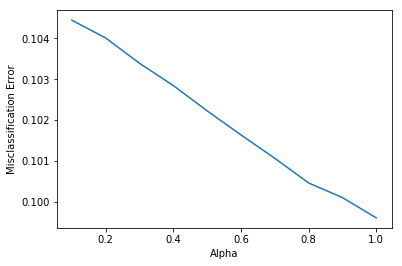

In [20]:
# plot misclassification error vs alpha
plt.plot(alpha, cv_error)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [21]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 89.4336649627146


array([[12868,  6198],
       [ 5336, 84756]], dtype=int64)

### Let's try different range for alpha

In [24]:
start = time.time()
# creating odd list of alpha for NB
alpha = np.linspace(1,10,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for a in alpha:
    # Create an object of the class KNeighborsClassifier
    clf = MultinomialNB(alpha = a)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_alpha = alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_alpha)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal number of neighbors is 2.0
Total time in minutes =  1.1005320310592652


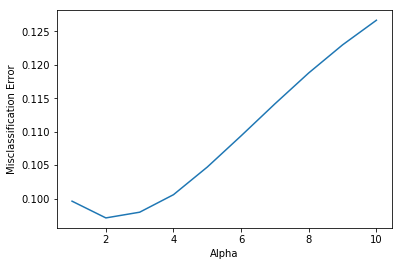

In [25]:
# plot misclassification error vs alpha
plt.plot(alpha, cv_error)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [26]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 89.61505340882024


array([[11863,  7203],
       [ 4133, 85959]], dtype=int64)

### Model Interpretability

In [28]:
idx = (-clf.feature_log_prob_).argsort()[:2,:50]
print("Top 50 words in negative reviews")
for i in idx[0]:
    print(bow.get_feature_names()[i])
    
print("\n******************************************\n")
print("Top 50 words in positive reviews")
for i in idx[1]:
    print(bow.get_feature_names()[i])

Top 50 words in negative reviews
tast
like
product
one
flavor
would
tri
good
coffe
use
get
buy
order
food
tea
box
even
amazon
make
bag
much
time
eat
realli
look
love
packag
review
purchas
dog
bought
first
disappoint
bad
chocol
better
want
cup
price
also
think
know
sugar
could
made
water
say
drink
ingredi
well

******************************************

Top 50 words in positive reviews
like
tast
good
flavor
love
great
use
one
product
tea
tri
coffe
make
get
food
time
would
buy
amazon
eat
realli
find
price
best
also
much
order
littl
store
well
bag
drink
dog
even
mix
chocol
cup
better
year
day
sugar
recommend
sweet
box
high
found
water
free
treat
first
